# Reddit dataset
## 1. Replication of figure 1A: Log-log plot of the complementary cumulative distribution functions of the number of comments per user on Reddit

### 1.1 Data collection
For this step, we will be using data collected using the Reddit PushShift API (https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/), and hosted on Google Cloud. We will use the BigQuery API to collect the data from reddit, focusing on the first years of existence of the platform.<br>
Collecting data from 2005, the year Reddit was created, should allow us to get a representative set of comments for the users. Indeed, we'll have access to the history of their profile from their date of creation.
We'll collect data until for the time period : 2005-2009.

In [1]:
#usual imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#to make calls to the BigQuery API, we'll also need to import the following:
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from google.cloud import bigquery_storage
import google.cloud.bigquery_storage_v1.client
import google.auth
from google.oauth2 import service_account
from functools import partialmethod

Let's fetch our data by passing SQL requests to the BigQuery API. For each comment, we are interested in its date of creation, its author and its reference (id)

In [2]:
# Set a two hours timeout for the API calls
google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 

#set up the credentials and the reference to the dataset hosted on Google cloud
credentials = service_account.Credentials.from_service_account_file('My First Project-ff75947ad69d.json')
your_project_id = 'crypto-parser-298009'
bqclient = bigquery.Client(credentials=credentials, project=your_project_id)

#define the SQL request to get the desired information and iterate between datasets to get all comments from 2005 to 2009
#the data is concatenated in the df_reddit dataframe
query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments.2005`"""
df_reddit = bqclient.query(query_string).to_dataframe()
for i in range(2006,2009):
    query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments."""+str(i)+'`'
    df2_reddit = bqclient.query(query_string).to_dataframe()   
    df_reddit=df_reddit.append(df2_reddit, ignore_index=True)    
df_reddit.head()

,author,created_utc,id
0,[deleted],1135524272,c1996
1,[deleted],1135528315,c1999
2,paulgraham,1135522009,c1992
3,cg84,1135525426,c1997
4,paulgraham,1135521881,c1991


In [3]:
print('number of comments fetched: '+ str(len(df_reddit.id.unique())))
print('number of unique users fetched: '+ str(len(df_reddit.author.unique())))

number of comments fetched: 9388316
number of unique users fetched: 153062


We can see that we fetched more than 9 million comments from more than 150000 users. Many of these profiles seem to have been deleted. Let's remove the comments from deleted users.

In [4]:
#remove comments from deleted users
df_reddit = df_reddit[df_reddit.author != '[deleted]']
print('number of comments fetched from existing users: '+ str(len(df_reddit.id.unique())))

number of comments fetched from existing users: 6351117


Unfortunately, data about the location of Reddit users does not seem to be publically available. This means that if we wanted to reproduce the trends in usage using this dataset, we would only be using the time in the UTC timezone. This would not make much sense, thus we will not use this data to reproduce the figures 2 from the testing propositions paper.<br>

Nevertheless, out of curiosity let's see what those graphs would look like:

### Extra experiment: Circadian rhythms for Reddit using UTC time only.

In [5]:
#we copy our dataframe to an experimental one and run some pre-processing to format it correctly
data=df_reddit.copy()

#convert the creation time to a datetime object and extract the weekday and hour of the day
data['local_datetime'] = pd.to_datetime(data['created_utc'] , unit='s')
data['weekday'] = pd.DatetimeIndex(data['local_datetime']).strftime("%A")
data['time_hour'] = pd.DatetimeIndex(data['local_datetime']).hour

data.head()

,author,created_utc,id,local_datetime,weekday,time_hour
2,paulgraham,1135522009,c1992,2005-12-25 14:46:49,Sunday,14
3,cg84,1135525426,c1997,2005-12-25 15:43:46,Sunday,15
4,paulgraham,1135521881,c1991,2005-12-25 14:44:41,Sunday,14
5,polexa,1135522774,c1994,2005-12-25 14:59:34,Sunday,14
6,alv,1135526478,c1998,2005-12-25 16:01:18,Sunday,16


In [6]:
#group by day and hour of the day
daily_activity_exp = data.groupby(['weekday','time_hour'],as_index=False)

#create a dataframe with the number of posts and unique users at any given hour of any given day
users_stats_reddit_exp=daily_activity_exp.nunique()

users_stats_reddit_exp.head()

,weekday,time_hour,author,created_utc,id,local_datetime
0,Friday,0,11337,38857,41933,38857
1,Friday,1,11023,37603,40485,37603
2,Friday,2,10704,36254,39052,36254
3,Friday,3,10677,36111,38796,36111
4,Friday,4,10202,33666,36070,33666


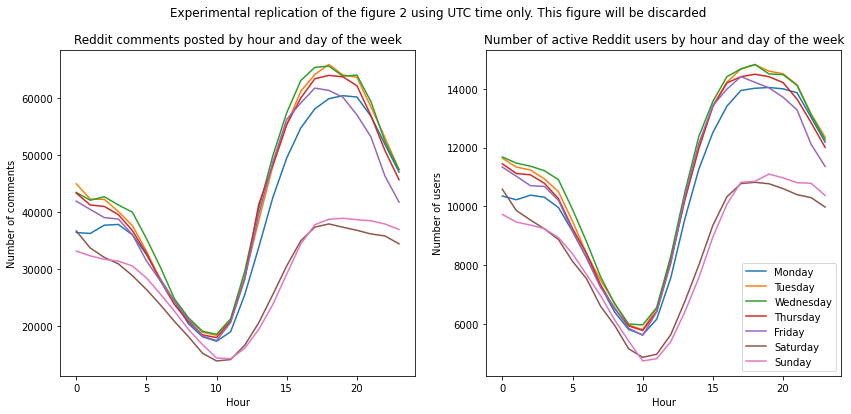

In [7]:
days=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(1, 2, figsize=(14,6), sharex = True)
fig.suptitle('Experimental replication of the figure 2 using UTC time only. This figure will be discarded')    

for day in days:
    #take data for one day at a time
    daily_reddit_exp=users_stats_reddit_exp[users_stats_reddit_exp.weekday==day]
    #plot number of comments and number of users that commented as a function of the hour
    axs[0].plot(daily_reddit_exp.time_hour,daily_reddit_exp.id,label=day)
    axs[1].plot(daily_reddit_exp.time_hour,daily_reddit_exp.author,label=day)
    

axs[0].set_title('Reddit comments posted by hour and day of the week')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Number of comments')
axs[1].set_title('Number of active Reddit users by hour and day of the week')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Number of users')
axs[1].legend()

As expected, making sense of these figures is difficult. We could have as an hypothesis that the majority of the reddit userbase is located in the US, especially in the first years of the platform and shift these graphs, but due to the fact that there are several timezones within the US, **will simply disregard these plot for the rest of this project.**  <br> <br>
But let's go back to our focus: creating a similar graph to the figure 1A from our paper.

### 1.2 Pre-processing of the data
In order to reuse the method from the replication task P2, we'll need to obtain a dataframe with a similar formatting to the one we had. Indeed, we'll need to have the number of comments for each user.

In [8]:
#for now our data has the following formatting
df_reddit.head()

,author,created_utc,id
2,paulgraham,1135522009,c1992
3,cg84,1135525426,c1997
4,paulgraham,1135521881,c1991
5,polexa,1135522774,c1994
6,alv,1135526478,c1998


In [9]:
#group our data by author and fetch the number of posts per user
grouped_by_users=df_reddit.groupby(['author'],as_index=False)
users=pd.DataFrame(grouped_by_users.size())

#rename columns for clarity
users=users.rename(columns={'size': 'comments_count'})

users.head()

,author,comments_count
0,-------,1
1,--------------------,7
2,--Aly95--,1
3,--GOD--,25
4,--k,1


Now that the pre-processing is done, we only need to re-use our method to create our figure and observe our CCDF of the number of comments per user on Reddit.
We note that we won't be able to reproduce the N>=0 line since our original dataset is made of comments and thus we don't have any users with 0 comments.
### 1.3 Figure creation

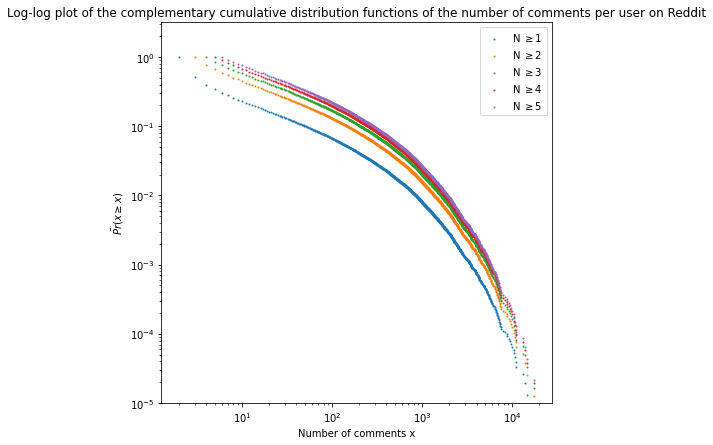

In [10]:
plt.figure(figsize=(7,7))

#We compute the ordonned list of occurences of each number of comments: 
#comments_bincount = [nbr of users with 0 comments, nbr of users with 1 comments, ... , nbr of users with max_number comments]
comments_bincount = np.bincount(users.comments_count)

#Using comments_bincount, we fill comments_sum[i] with the sum of all users having more than i comments:
#comments_sum = [nbr of users with at least 0 comments, nbr of users with at least 1 comments, ... , nbr users with at least max_number comments]
comments_sum=np.ones(len(comments_bincount))*comments_bincount.sum()
comments_sum[1:]-=np.cumsum(comments_bincount)[:-1]
        
#In our case, we won't be able to observe the number of users with 0 comments since our dataset is created from comments    
for i in range(1,6):
    #We isolate the comments_sum values for the sample N>=i and convert to proportions to get the CCDF 
    #(by dividing by the total number of users in the desired sample)
    ccdf=comments_sum[i:]
    ccdf=ccdf/ccdf[0]
    
    #The x vector contains the range of comments for our sample, 
    #we need to adjust its dimensions to avoid having a zero in it (due to the use of the logarithm for our plot) 
    x=list(range(min(users[users.comments_count>=i].comments_count.values.astype(int))+1, \
                 max(users[users.comments_count>=i].comments_count.values.astype(int))+2))
    
    #If the probability does not change between two consecutive x, it means that the element had 0 occurence in comments_bincount
    #In order to eliminate the duplicates in the plot, we fill a dataframe with x and ccdf 
    #and use the df.drop_duplicates function.
    xy=pd.DataFrame(data=None)
    xy['x']=x
    xy['ccdf']=ccdf
    xy=xy.drop_duplicates(subset='ccdf',keep='last')
    plt.scatter(xy.x.values,xy.ccdf.values,s=1,label="N $\geq$"+str(i))
    plt.loglog()

#Plot config
plt.ylim([10**(-5),10**0.5])
plt.xlabel('Number of comments x')
plt.ylabel(r'$\bar{Pr}(x \geq x)$')
plt.title('Log-log plot of the complementary cumulative distribution functions of the number of comments per user on Reddit')
plt.legend()
plt.show()

## 2. Replication of figure 2: Daily and weekly rhythms of Reddit activity

### 2.1 Data collection
This time, we need to be able to determine the user's location to ensure the time of creation of all the comments are comparable. To address this, we will be using only the comments from the "/r/France" subreddit (from the “French Reddit Discussion” on Kaggle https://www.kaggle.com/breandan/french-reddit-discussion), and assuming that those who comment on it in french are located in France.<br>

The dataset is orignally provided as an .xml file, but python scripts are provided to convert it to .csv. It originally contains 556,621 conversations with 1,583,083 comments in total, from several french-speaking reddit communities (subreddits). Since this conversion is extremely time consuming, we will be extracting 100000 conversations from the original set, which contains 272708 comments. We will also need to extract the comments from /r/France to satisfy our hypothesis.

In [11]:
#import the data from our converted dataset
french_discussion = pd.read_csv('data/Reddit_Conv_french.csv')

#rename the columns for clarity
french_discussion=french_discussion.rename(columns={'uid': 'id'})

french_discussion.head()

,Unnamed: 0,link_id,subreddit_id,id,comment_id,score,parent_id,create_utc,text
0,0,8r1kz,2qhjz,1688932,c0a62uj,3,8r1kz,1244576002,Ironie : l'article disant qu'on est plus capab...
1,1,8r1kz,2qhjz,786883,c0a6lmb,1,c0a62uj,1244621120,"Moi-même, j'ai dû me forcer pour arriver jusqu..."
2,2,8sncs,2qhjz,390497,c0aawpk,1,8sncs,1245076061,Service qui sera rendu au contribuable pour la...
3,3,8sncs,2qhjz,32884,c0aaxba,3,c0aawpk,1245077396,Eeeeh oui ! 70 millions pour une loi qui aura ...
4,4,8v13c,2qhjz,796919,c0aj3ov,2,8v13c,1245830384,Est-ce qu'elle a vraiment commis des crimes qu...


In [12]:
print('number of comments: '+ str(len(french_discussion.comment_id.unique())))
print('number of unique users: '+ str(len(french_discussion.id.unique())))

number of comments: 272708
number of unique users: 272708


We can already see a limitation of our dataset: the users are all unique. This limitation will not allow us to create a significative comparison between the comments posted and the active users by hour and day of the week. **We will then focus on the first distribution: the number of comments posted on the platform.**
### 2.2 Pre-processing of the data

In [13]:
#only keep comments from the /r/france subreddit. we can make the assumption that the users that comment in this subreddit are french and thus located in France.
#https://www.reddit.com/r/france/about.json gives us the subreddit id that we need to keep: 2qhjz
france_posts = french_discussion[french_discussion.subreddit_id == '2qhjz']
france_posts.head()

,Unnamed: 0,link_id,subreddit_id,id,comment_id,score,parent_id,create_utc,text
0,0,8r1kz,2qhjz,1688932,c0a62uj,3,8r1kz,1244576002,Ironie : l'article disant qu'on est plus capab...
1,1,8r1kz,2qhjz,786883,c0a6lmb,1,c0a62uj,1244621120,"Moi-même, j'ai dû me forcer pour arriver jusqu..."
2,2,8sncs,2qhjz,390497,c0aawpk,1,8sncs,1245076061,Service qui sera rendu au contribuable pour la...
3,3,8sncs,2qhjz,32884,c0aaxba,3,c0aawpk,1245077396,Eeeeh oui ! 70 millions pour une loi qui aura ...
4,4,8v13c,2qhjz,796919,c0aj3ov,2,8v13c,1245830384,Est-ce qu'elle a vraiment commis des crimes qu...


In [14]:
print('number of comments from /r/France: '+ str(len(france_posts.comment_id.unique())))

number of comments from /r/France: 267840


We can see that we kept the bulk of the data, which is preferable.

In [15]:
#keep only the necessary columns from the dataset
france_posts=france_posts[['id', 'create_utc', 'comment_id']].copy()

#convert the creation time to a datetime object and extract the weekday and hour of the day
#we also add an offset of 1h to go from the utc timezone to the french timezone (utc+1)
france_posts['local_datetime'] = pd.to_datetime(france_posts['create_utc'] , unit='s') + pd.Timedelta(pd.offsets.Hour(1))
france_posts['weekday'] = pd.DatetimeIndex(france_posts['local_datetime']).strftime("%A")
france_posts['time_hour'] = pd.DatetimeIndex(france_posts['local_datetime']).hour
france_posts.head()

,id,create_utc,comment_id,local_datetime,weekday,time_hour
0,1688932,1244576002,c0a62uj,2009-06-09 20:33:22,Tuesday,20
1,786883,1244621120,c0a6lmb,2009-06-10 09:05:20,Wednesday,9
2,390497,1245076061,c0aawpk,2009-06-15 15:27:41,Monday,15
3,32884,1245077396,c0aaxba,2009-06-15 15:49:56,Monday,15
4,796919,1245830384,c0aj3ov,2009-06-24 08:59:44,Wednesday,8


In [16]:
#group by day and hour of the day
daily_activity_reddit = france_posts.groupby(['weekday','time_hour'],as_index=False)

#create a dataframe with the number of posts and unique users at any given hour of any given day
users_stats_reddit=daily_activity_reddit.nunique()
users_stats_reddit.head()

,weekday,time_hour,id,create_utc,comment_id,local_datetime
0,Friday,0,892,891,892,891
1,Friday,1,577,577,577,577
2,Friday,2,318,318,318,318
3,Friday,3,216,216,216,216
4,Friday,4,197,197,197,197


In [17]:
#we save this data to a .csv file to be reused later in the project
users_stats_reddit.to_csv('users_stats_reddit.csv')

### 2.3 Figure creation

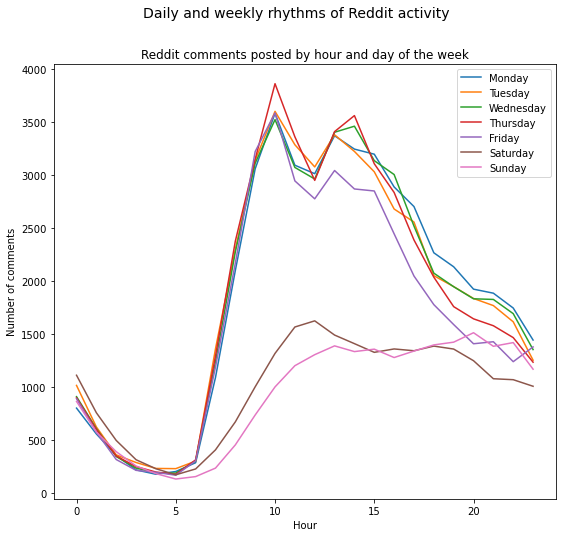

In [18]:
days=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(9,8))

for day in days:
    #take data for one day at a time
    daily_reddit=users_stats_reddit[users_stats_reddit.weekday==day]
    #plot number of comments as a function of the hour
    plt.plot(daily_reddit.time_hour,daily_reddit.comment_id,label=day)
   
    
plt.title('Reddit comments posted by hour and day of the week')
plt.xlabel('Hour')
plt.ylabel('Number of comments')
plt.suptitle('Daily and weekly rhythms of Reddit activity',fontsize=14)
plt.legend()